In [225]:
# Set filenames & co to quickly change file
file = 'jahr_300dpi'
folder = 'test-files'
filename_scan = f'{folder}/{file}.png'
filename_svg = f'{folder}/improved_{file}.svg'

# Either use multiprocessing (gain speed but loose the plot) or not
use_multiprocessing = True
filename_result_figure = f'{folder}/out_{file}.png'

## Import image

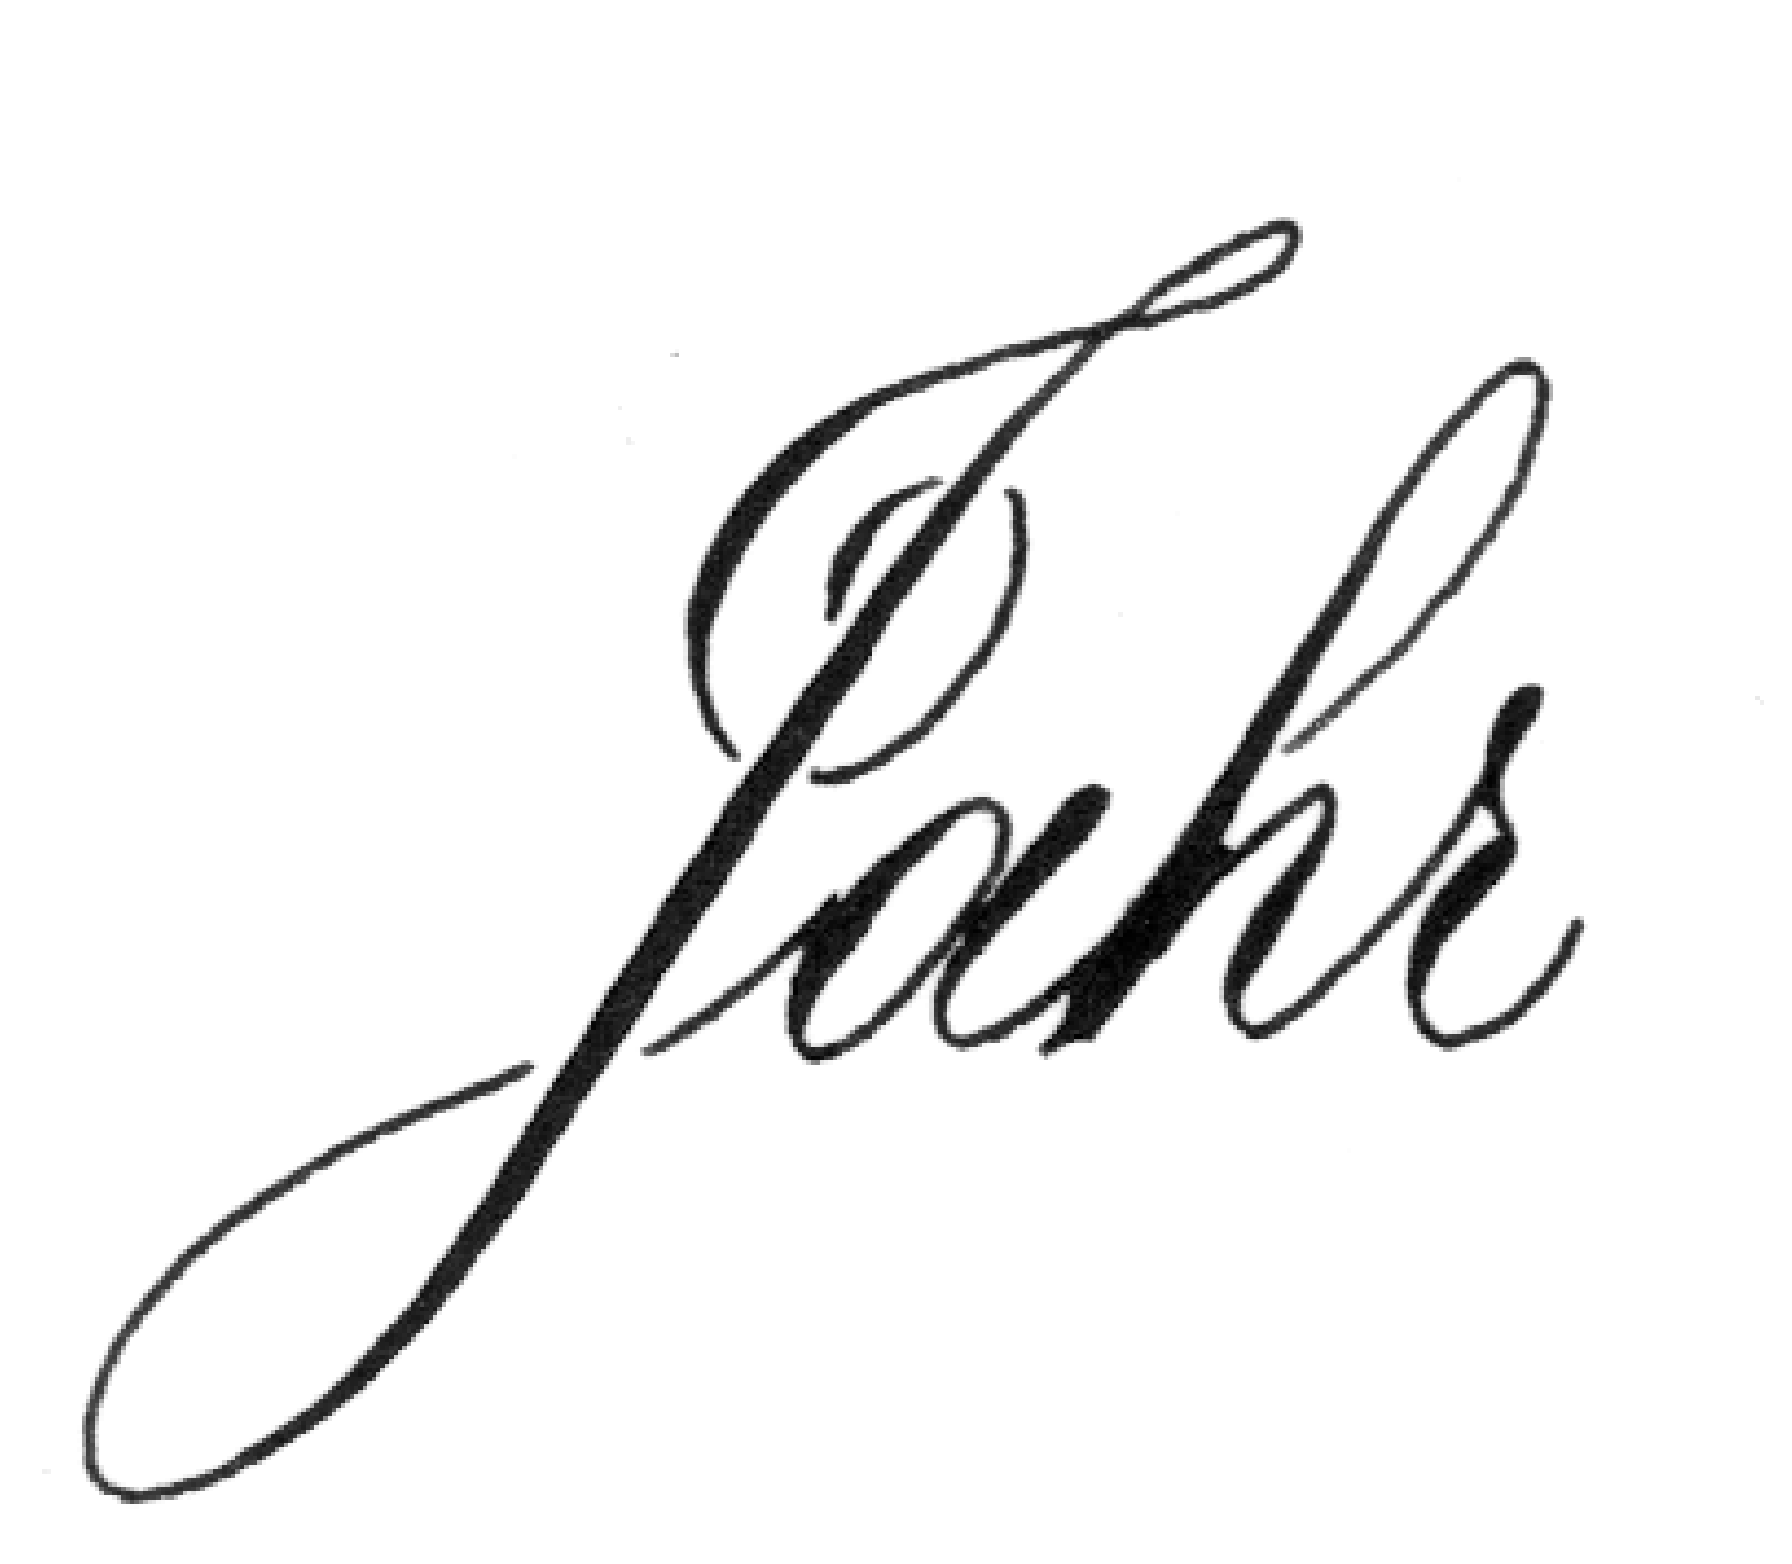

In [226]:
from skimage.io import imread, imshow

image_scan = imread(filename_scan, as_gray=True)
imshow(image_scan)

## Convert image to binary

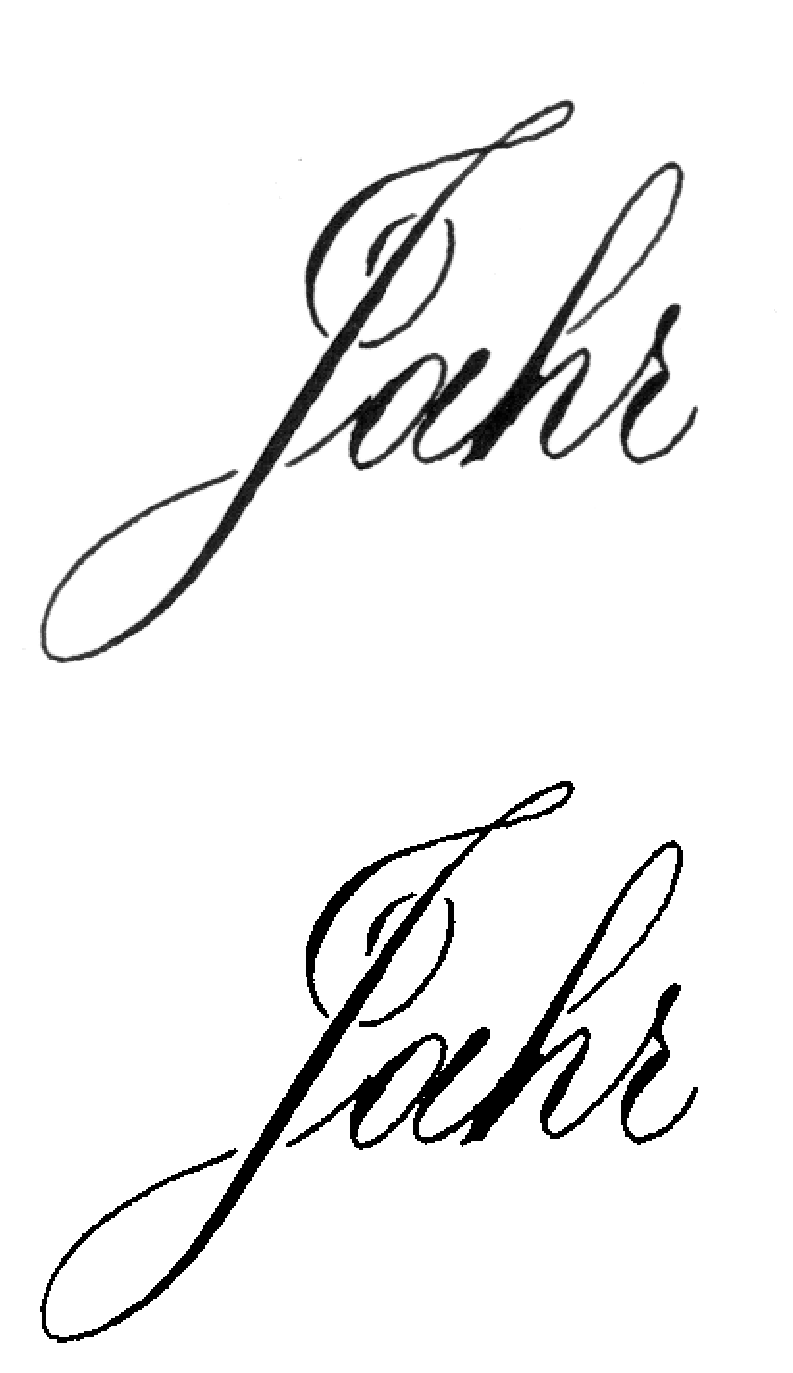

In [227]:
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# Set display size of all plt plots
plt.rcParams['figure.figsize'] = (25, 25)


# Hide axes
def hide_or_show_axes(show_axes):
    rc = {"axes.spines.left": show_axes,
          "axes.spines.right": show_axes,
          "axes.spines.bottom": show_axes,
          "axes.spines.top": show_axes,
          "xtick.bottom": show_axes,
          "xtick.labelbottom": show_axes,
          "ytick.labelleft": show_axes,
          "ytick.left": show_axes}
    plt.rcParams.update(rc)


hide_or_show_axes(False)

# Use Otsu's thresholding method to determine the threshold
threshold = threshold_otsu(image_scan)

# Create binary image
image_binary = image_scan > threshold

# Show the grayscale and binary image
plt.imshow(np.vstack((image_scan, image_binary)), cmap='gray',
           interpolation='nearest')

# from skimage.io import imsave
# imsave('comparison/ink_400.png', image_binary)

## Remove islands

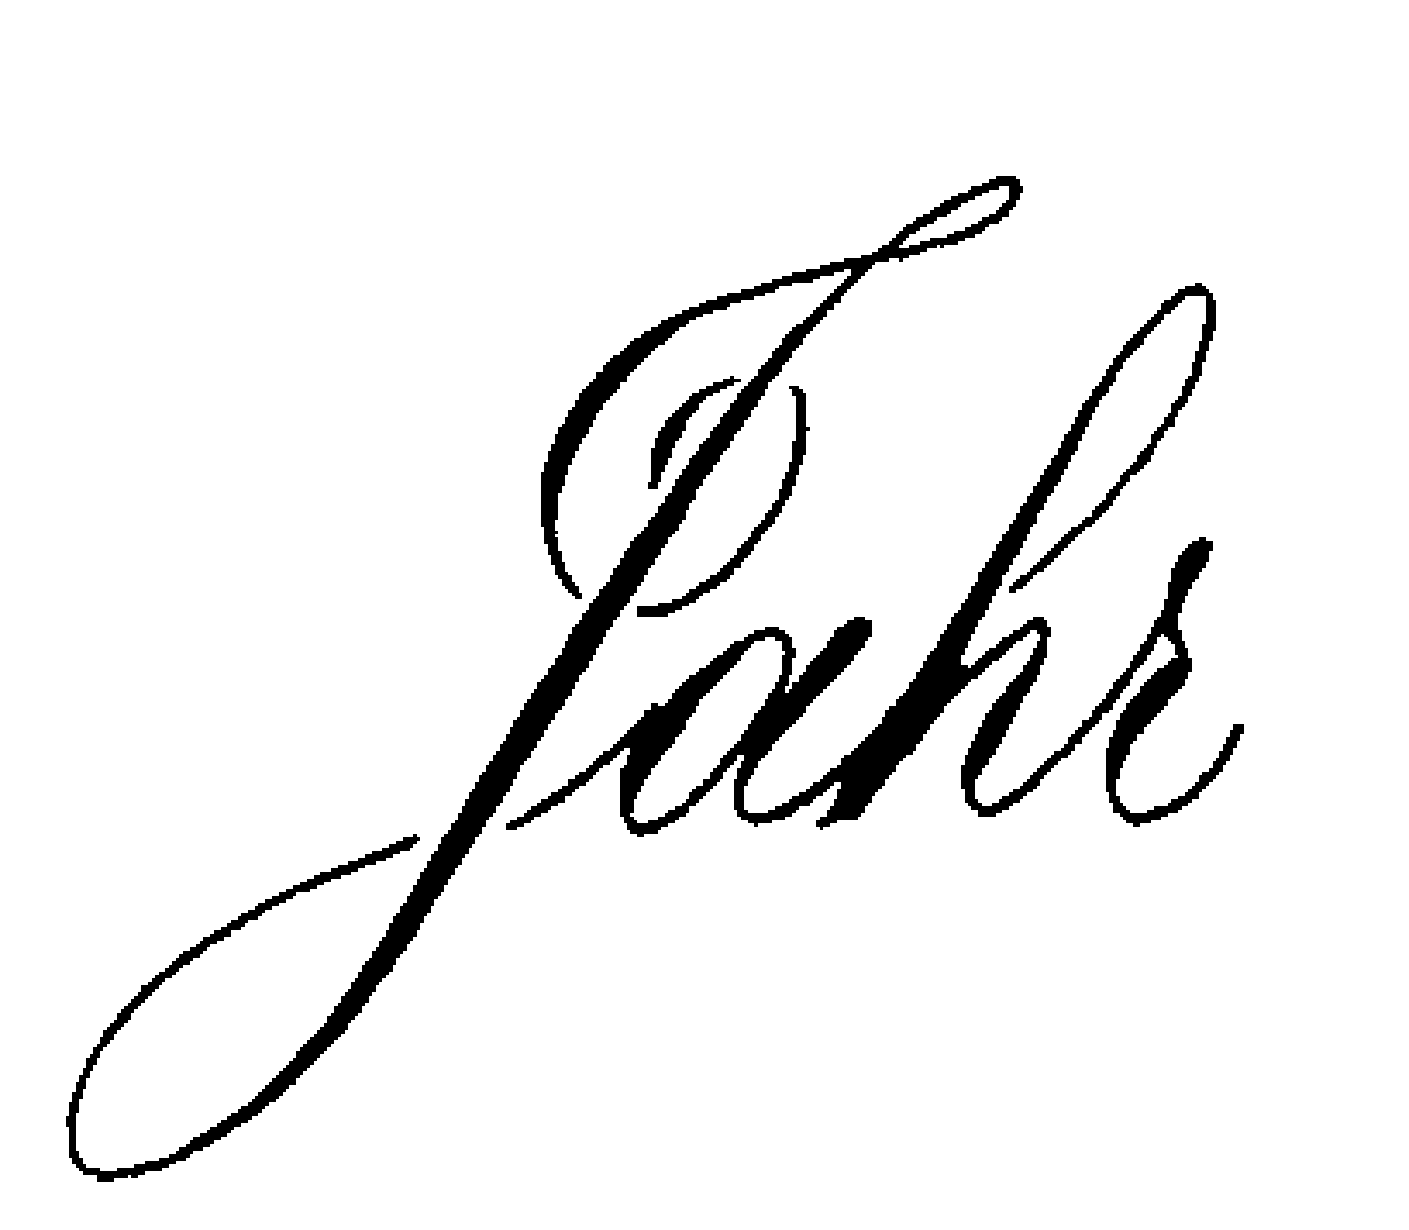

In [228]:
import skimage.morphology as mrp

# Use morphology methods to close small holes and open (remove) small pixel islands
image_cleaned = mrp.remove_small_holes(image_binary)
image_cleaned = mrp.remove_small_objects(image_cleaned)

plt.imshow(image_cleaned, cmap='gray', interpolation='nearest')

# from skimage.io import imsave
# imsave('comparison/test.png', image_cleaned)

## Trace contours

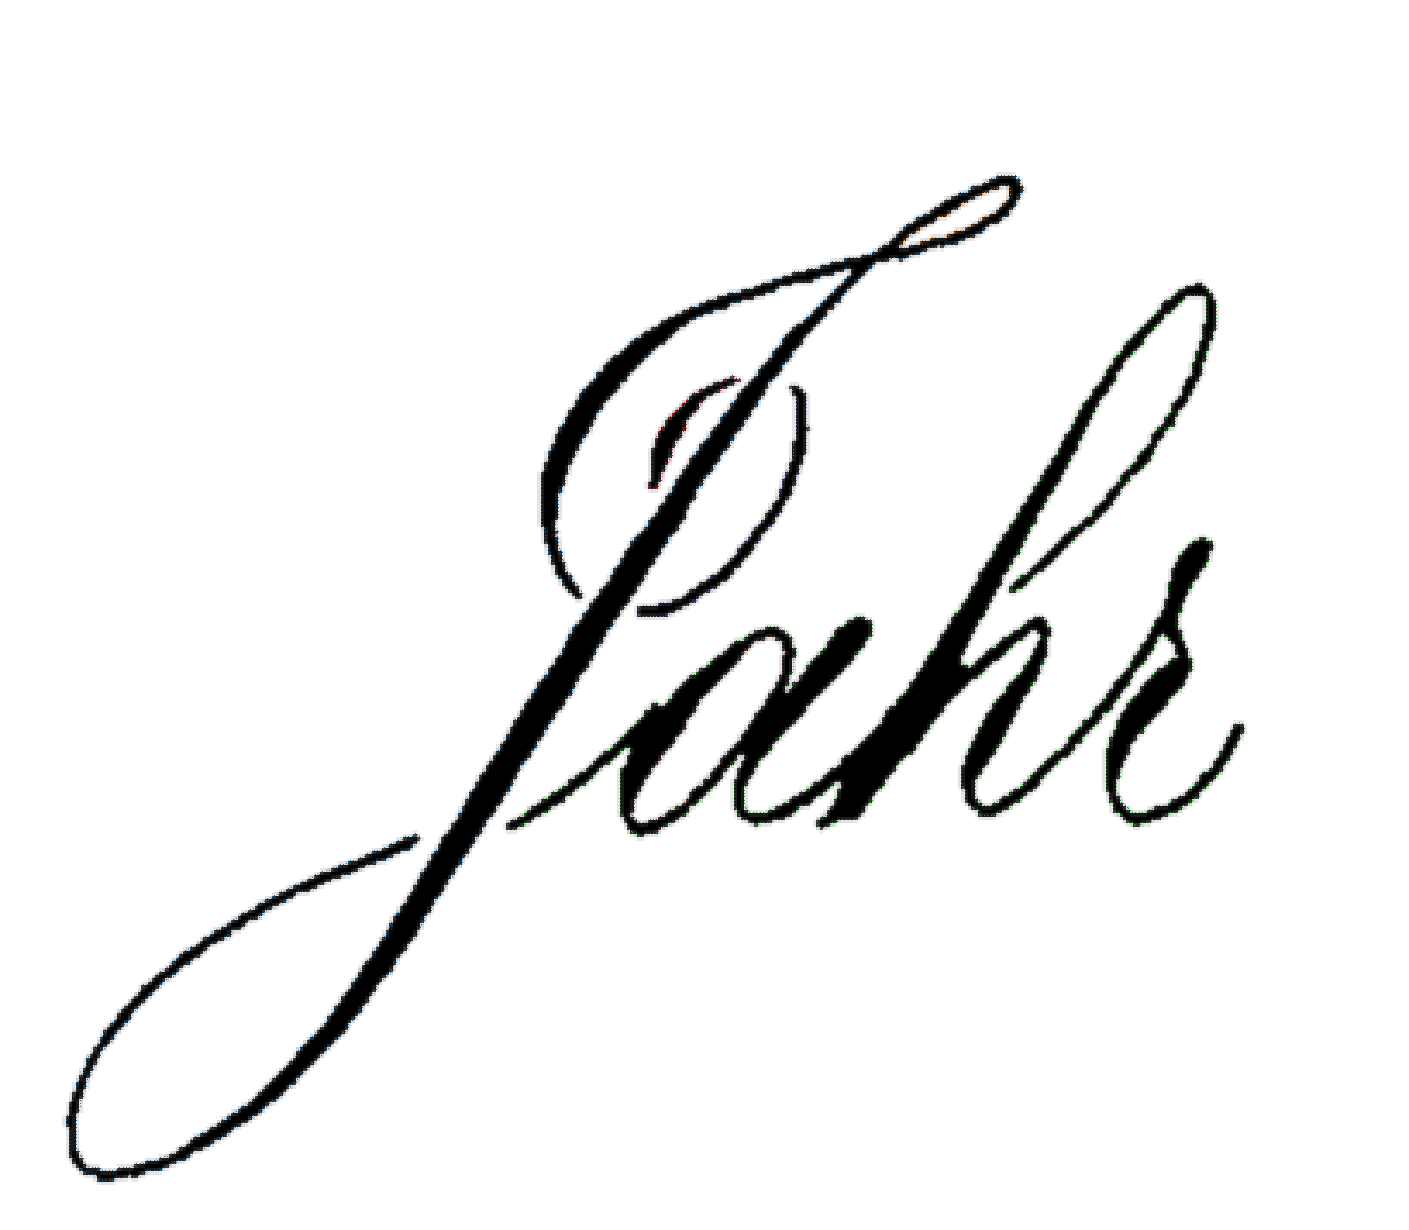

In [229]:
from skimage import measure
from skimage import filters

# Apply gaussian filter to slightly smoothen the edges
image_smoothened = filters.gaussian(image_cleaned, 0.5)

# Trace contours using skimage
contours = measure.find_contours(image_smoothened)

# Display the image and plot all contours
fig, ax = plt.subplots()
ax.imshow(image_smoothened, cmap='gray')
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], marker=',', linestyle='none')

## Get curvatures

In [230]:
from boundary_curvature import curvature

contours_with_curvatures = curvature.curvature(image_smoothened, 8, .1)

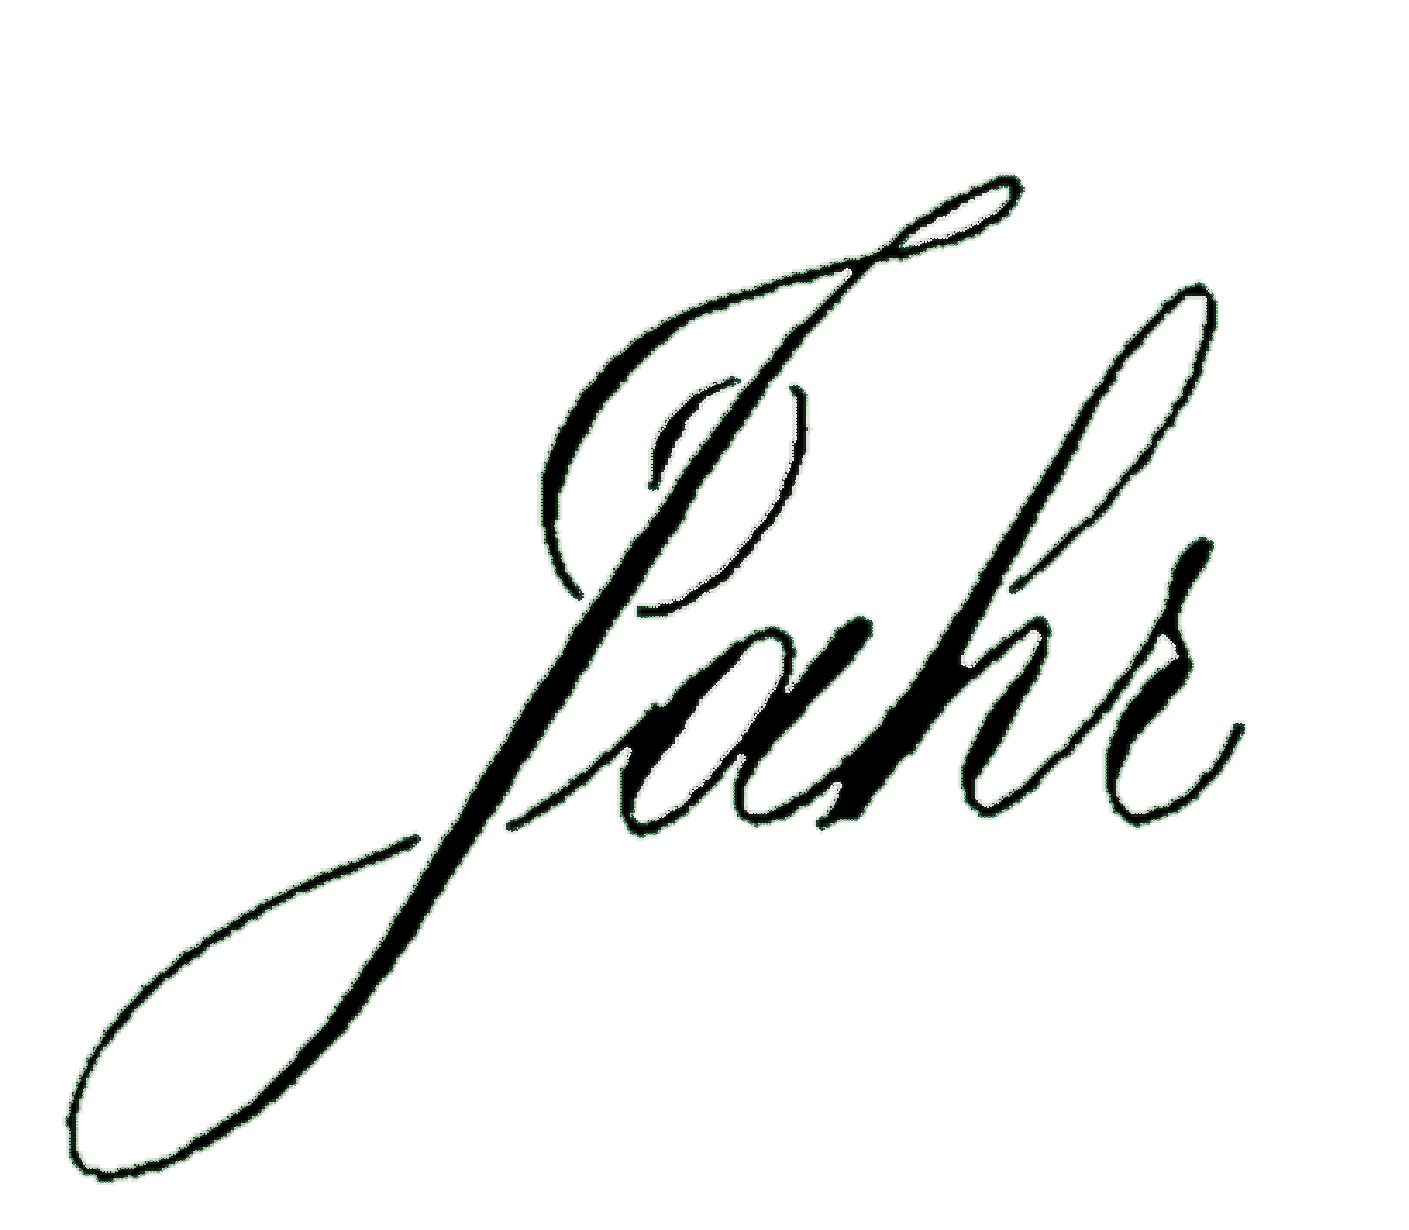

In [231]:
# Display the image and plot all contour curvatures
fig, ax = plt.subplots()
ax.imshow(image_smoothened, cmap='gray')
for contour in contours_with_curvatures:
    ax.scatter(contour[0][:, 0], contour[0][:, 1], c=contour[1], marker=',', s=1, cmap='Greens')

In [232]:
# From https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    #print(len(s))
    if window == 'flat':  #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w / w.sum(), s, mode='valid')
    return y

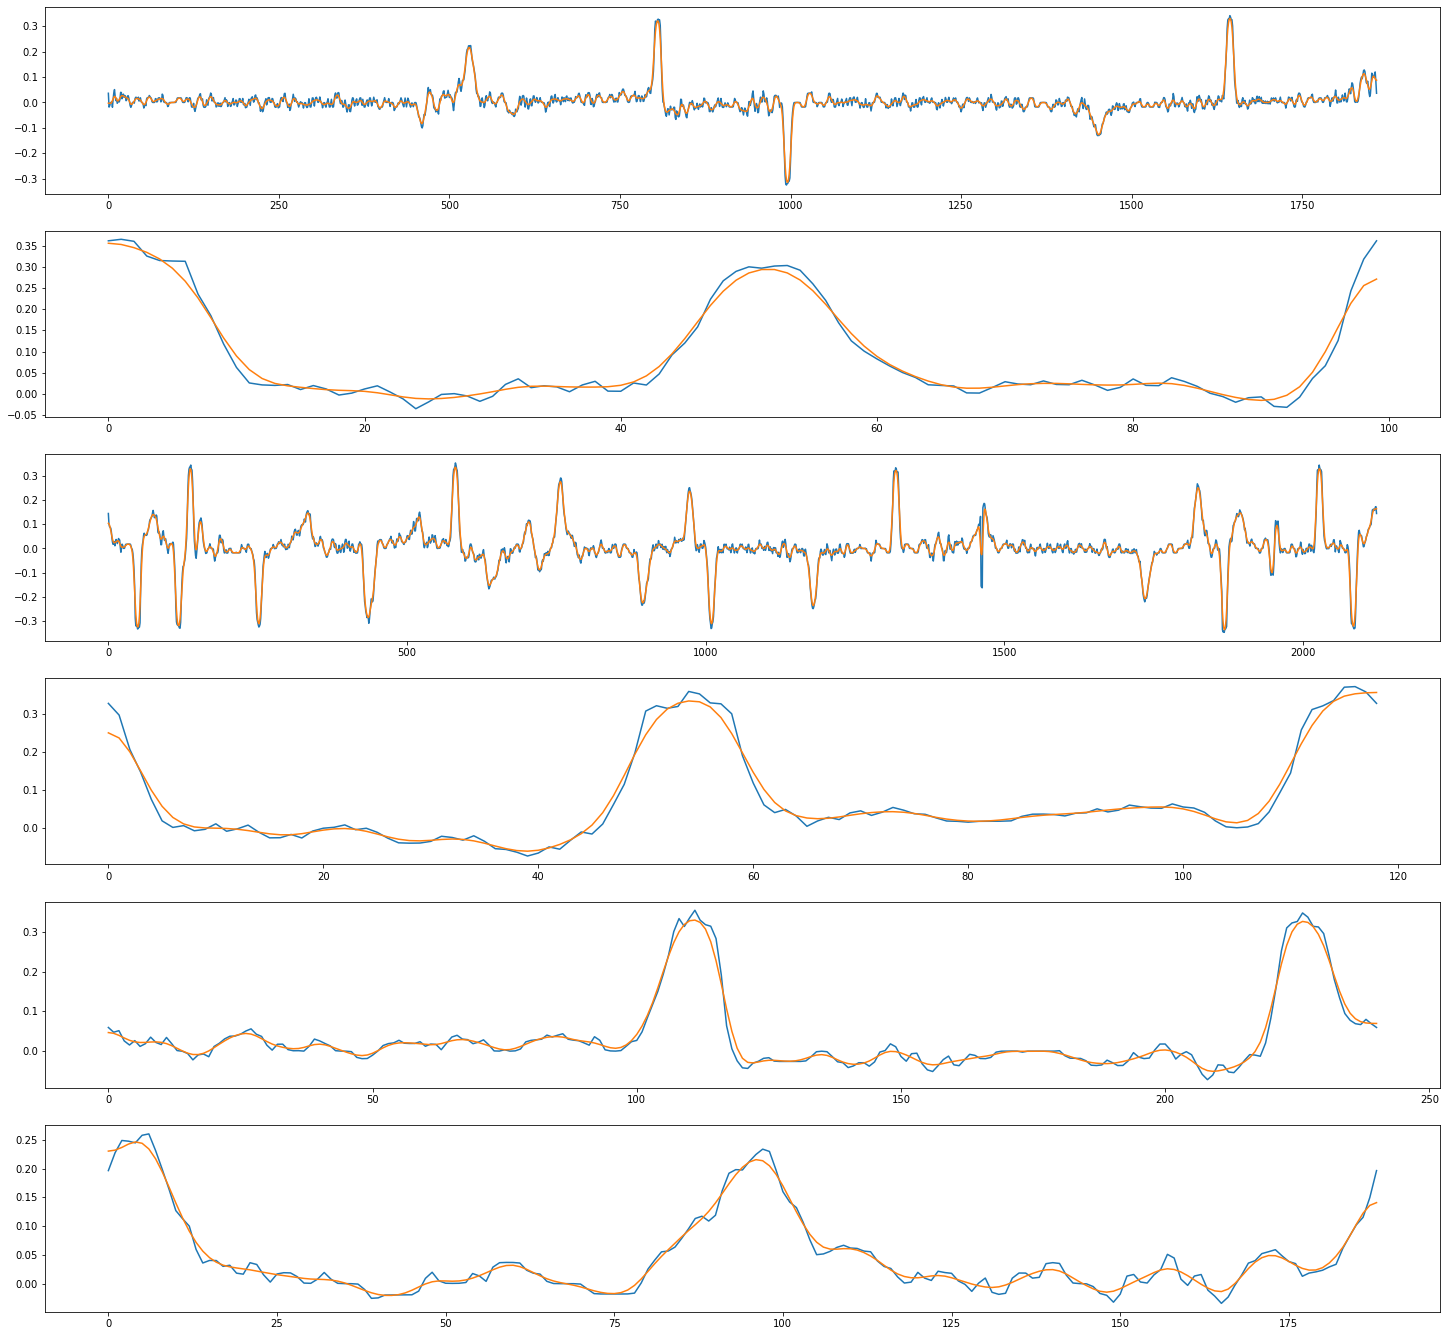

In [233]:
# Show all smoothened curvatures
hide_or_show_axes(True)

l = len(contours_with_curvatures)
fig, axs = plt.subplots(l, figsize=(25, 4 * l))

for i, contour_with_curvatures in enumerate(contours_with_curvatures):
    axs[i].plot(contour_with_curvatures[1])
    axs[i].plot(smooth(contour_with_curvatures[1])[5:-5])

hide_or_show_axes(False)

## Get extrema and determine corners

In [234]:
from scipy.signal import argrelmax

# Get curvature extrema
peaks = []
dips = []

for contour in contours_with_curvatures:
    smoothed_curvature = smooth(contour[1])[5:-5]
    peaks.append(argrelmax(smoothed_curvature, mode='wrap'))
    dips.append(argrelmax(-smoothed_curvature, mode='wrap'))

peaks = np.asarray(peaks, dtype=object)
dips = np.asarray(dips, dtype=object)

In [235]:
# Combine peaks and dips, filter out those where the difference is very small
from enum import Enum


class Extremum(Enum):
    PEAK = 1
    DIP = 0


def get_peak_or_dip_filter_condition(dip_or_peak: Extremum, curvature_array: np.ndarray, peak_array: np.ndarray,
                                     dip_array: np.ndarray, index: int, threshold: float = 0.1):
    """
    Get condition to sort out or keep peak or dip

    :param dip_or_peak: Whether it is about a peak or a dip
    :param curvature_array: Curvature values of contour
    :param peak_array: Peaks of contour
    :param dip_array: Dips of contour
    :param index: n-th peak or dip resp.
    :param threshold: Minimum absolute curvature difference between adjacent peaks/dips to classify as potential corner
    :return: True or false, depending on whether the extremum should be kept or not
    """
    current_array = peak_array if dip_or_peak else dip_array
    neighbor_array = dip_array if dip_or_peak else peak_array
    before = curvature_array.take(neighbor_array[index - 1], mode='wrap')
    current = curvature_array.take(current_array[index], mode='wrap')
    after = curvature_array.take(neighbor_array.take([index + 1], mode='wrap'), mode='wrap')
    return np.abs(before - current) > threshold and np.abs(
        after - current) > threshold


peaks_and_dips = []
for i, contour_peaks in enumerate(peaks):
    contour_peaks_and_dips = []
    curvature = contours_with_curvatures[i][1]
    for j in np.arange(0, len(contour_peaks[0])):
        peak = contour_peaks[0][j]
        dip = dips[i, 0][j]
        if peak < dip:
            if get_peak_or_dip_filter_condition(Extremum.PEAK, curvature, contour_peaks[0], dips[i, 0], j):
                contour_peaks_and_dips.append(np.array([peak, Extremum.PEAK.value]))
            if get_peak_or_dip_filter_condition(Extremum.DIP, curvature, contour_peaks[0], dips[i, 0], j):
                contour_peaks_and_dips.append(np.array([dip, Extremum.DIP.value]))
        else:
            if get_peak_or_dip_filter_condition(Extremum.DIP, curvature, contour_peaks[0], dips[i, 0], j):
                contour_peaks_and_dips.append(np.array([dip, Extremum.DIP.value]))
            if get_peak_or_dip_filter_condition(Extremum.PEAK, curvature, contour_peaks[0], dips[i, 0], j):
                contour_peaks_and_dips.append(np.array([peak, Extremum.PEAK.value]))

    contour_peaks_and_dips = np.asarray(contour_peaks_and_dips)
    if len(contour_peaks_and_dips) > 0:
        peaks_and_dips.append(contour_peaks_and_dips[contour_peaks_and_dips[:, 0] < len(curvature)])
    else:
        peaks_and_dips.append(contour_peaks_and_dips)

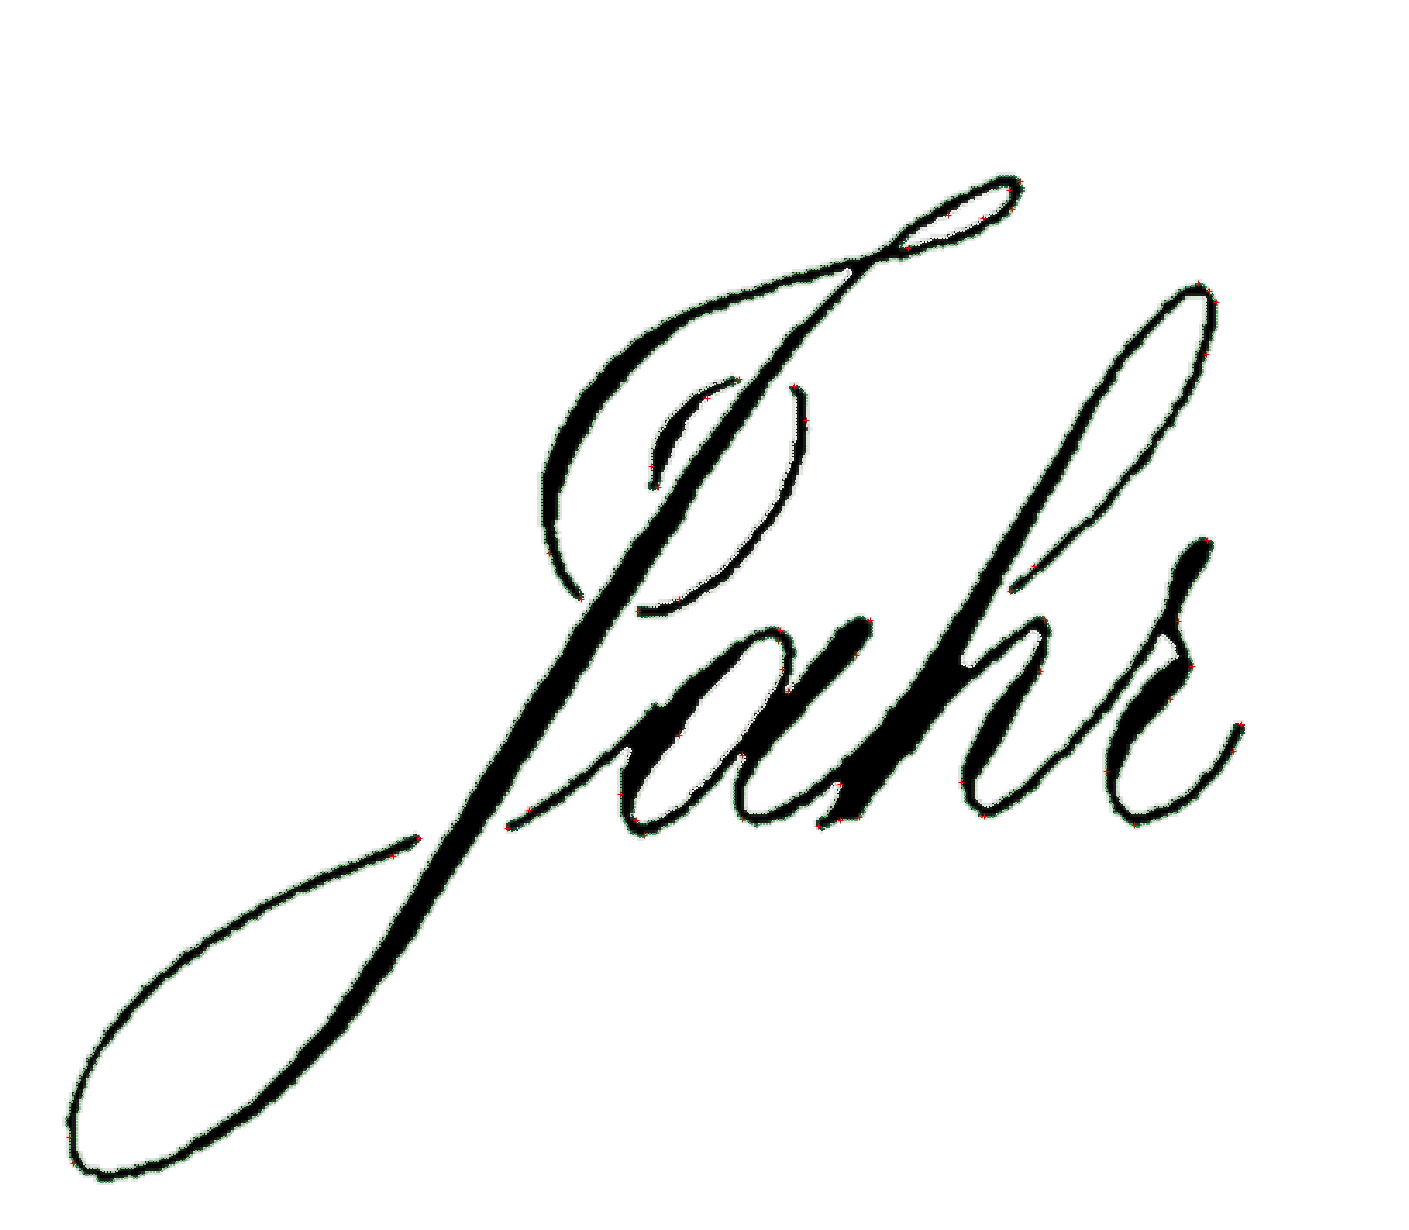

In [236]:
# Display the image and plot all contours and peaks/dips
fig, ax = plt.subplots()
ax.imshow(image_smoothened, cmap='gray')
for i, contour in enumerate(contours_with_curvatures):
    ax.scatter(contour[0][:, 0], contour[0][:, 1], c=contour[1], marker=',', s=1, cmap='Greens')
    if len(peaks_and_dips[i]) > 0:
        ax.plot(contour[0].take(peaks_and_dips[i][:, 0], axis=0)[:, 0],
                contour[0].take(peaks_and_dips[i][:, 0], axis=0)[:, 1], 'r+')

In [237]:
# Sort out points that are too close together

min_distance = 5

peaks_and_dips_with_min_distance = []
for i, contour_peaks_and_dips in enumerate(peaks_and_dips):
    filtered_peaks_and_dips = []
    if len(contour_peaks_and_dips) > 0:
        l_contour = len(contours_with_curvatures[i][0])
        l_extrema = len(contour_peaks_and_dips)
        for j, extremum in enumerate(contour_peaks_and_dips[:, 0]):
            # Handle first
            if j == 0:
                if l_extrema == 1:
                    filtered_peaks_and_dips.append(contour_peaks_and_dips[0])
                elif (extremum + contour_peaks_and_dips[:, 0][-1]) % l_contour > min_distance and (
                        contour_peaks_and_dips[:, 0][1] - extremum) > min_distance:
                    filtered_peaks_and_dips.append(contour_peaks_and_dips[j])
            # Handle last
            elif j == l_extrema - 1:
                if extremum - contour_peaks_and_dips[:, 0][j - 1] > min_distance and (
                        extremum + contour_peaks_and_dips[:, 0][0]) % l_contour > min_distance:
                    filtered_peaks_and_dips.append(contour_peaks_and_dips[j])
            # Standard case
            else:
                if (extremum - contour_peaks_and_dips[:, 0][j - 1]) > min_distance and (
                        contour_peaks_and_dips[:, 0][j + 1] - extremum) > min_distance:
                    filtered_peaks_and_dips.append(contour_peaks_and_dips[j])

    peaks_and_dips_with_min_distance.append(np.asarray(filtered_peaks_and_dips))

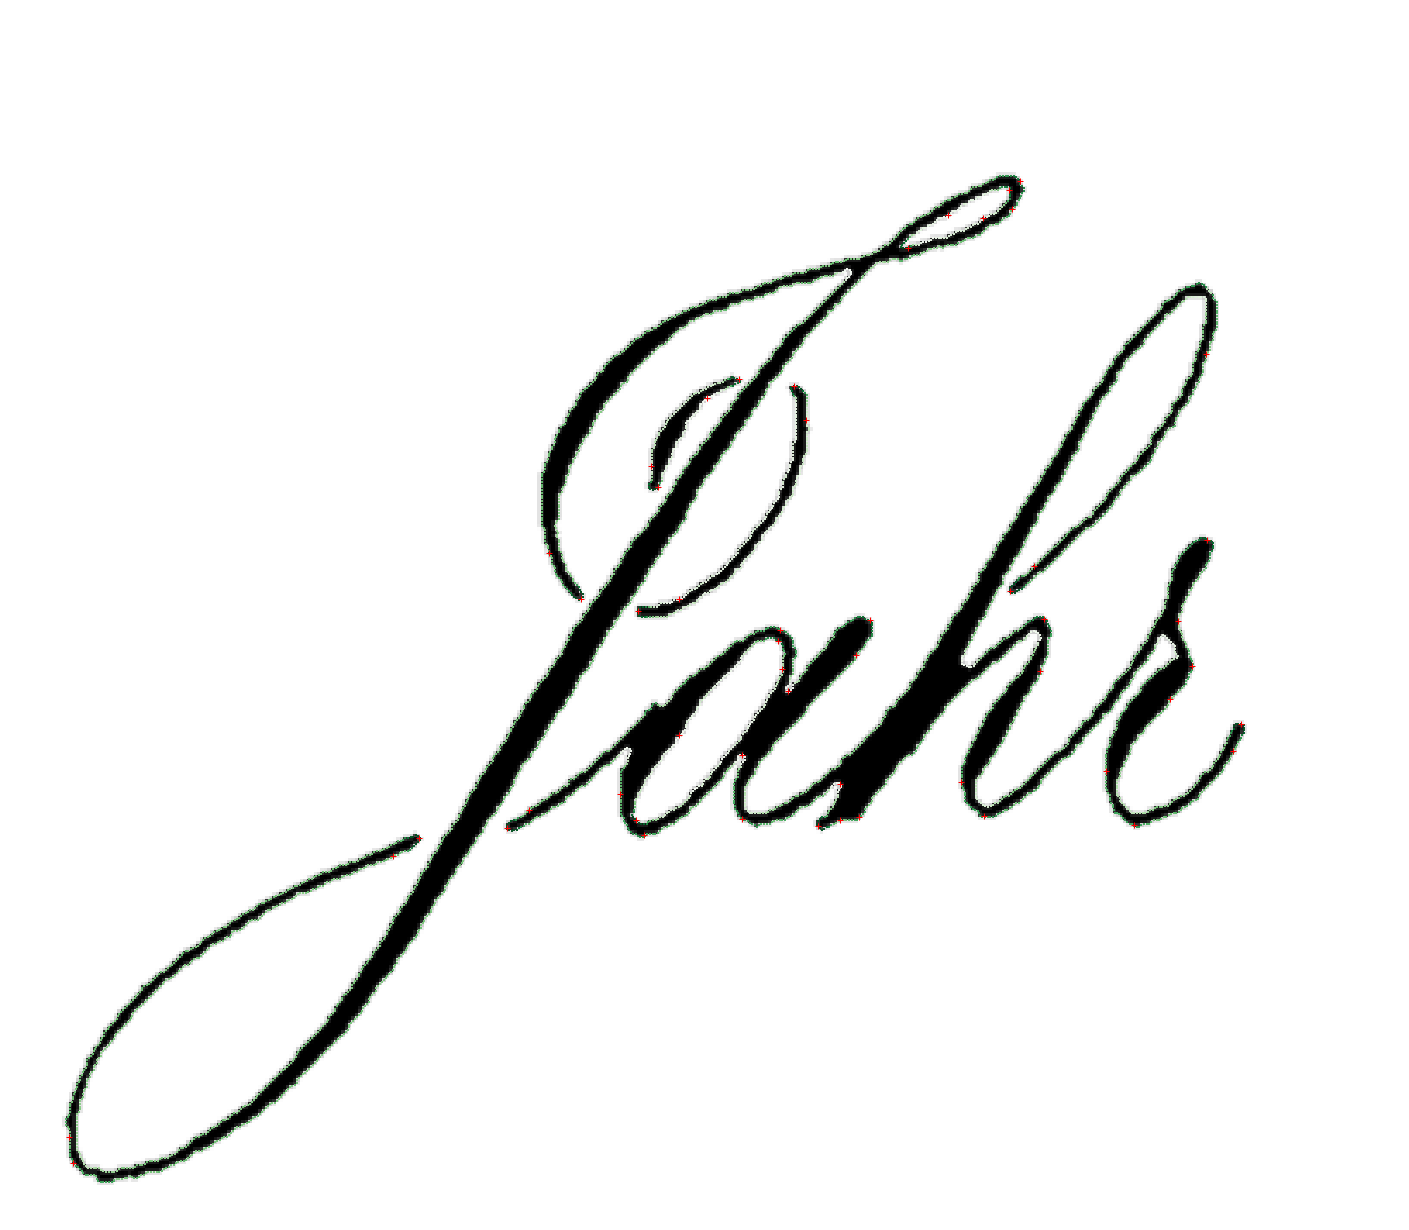

In [238]:
# Display the image and plot all contours and remaining peaks/dips
fig, ax = plt.subplots()
ax.imshow(image_smoothened, cmap='gray')
for i, contour in enumerate(contours_with_curvatures):
    ax.scatter(contour[0][:, 0], contour[0][:, 1], c=contour[1], marker=',', s=1, cmap='Greens')
    if len(peaks_and_dips_with_min_distance[i]) > 0:
        ax.plot(contour[0].take(peaks_and_dips_with_min_distance[i][:, 0], axis=0)[:, 0],
                contour[0].take(peaks_and_dips_with_min_distance[i][:, 0], axis=0)[:, 1], 'r+')

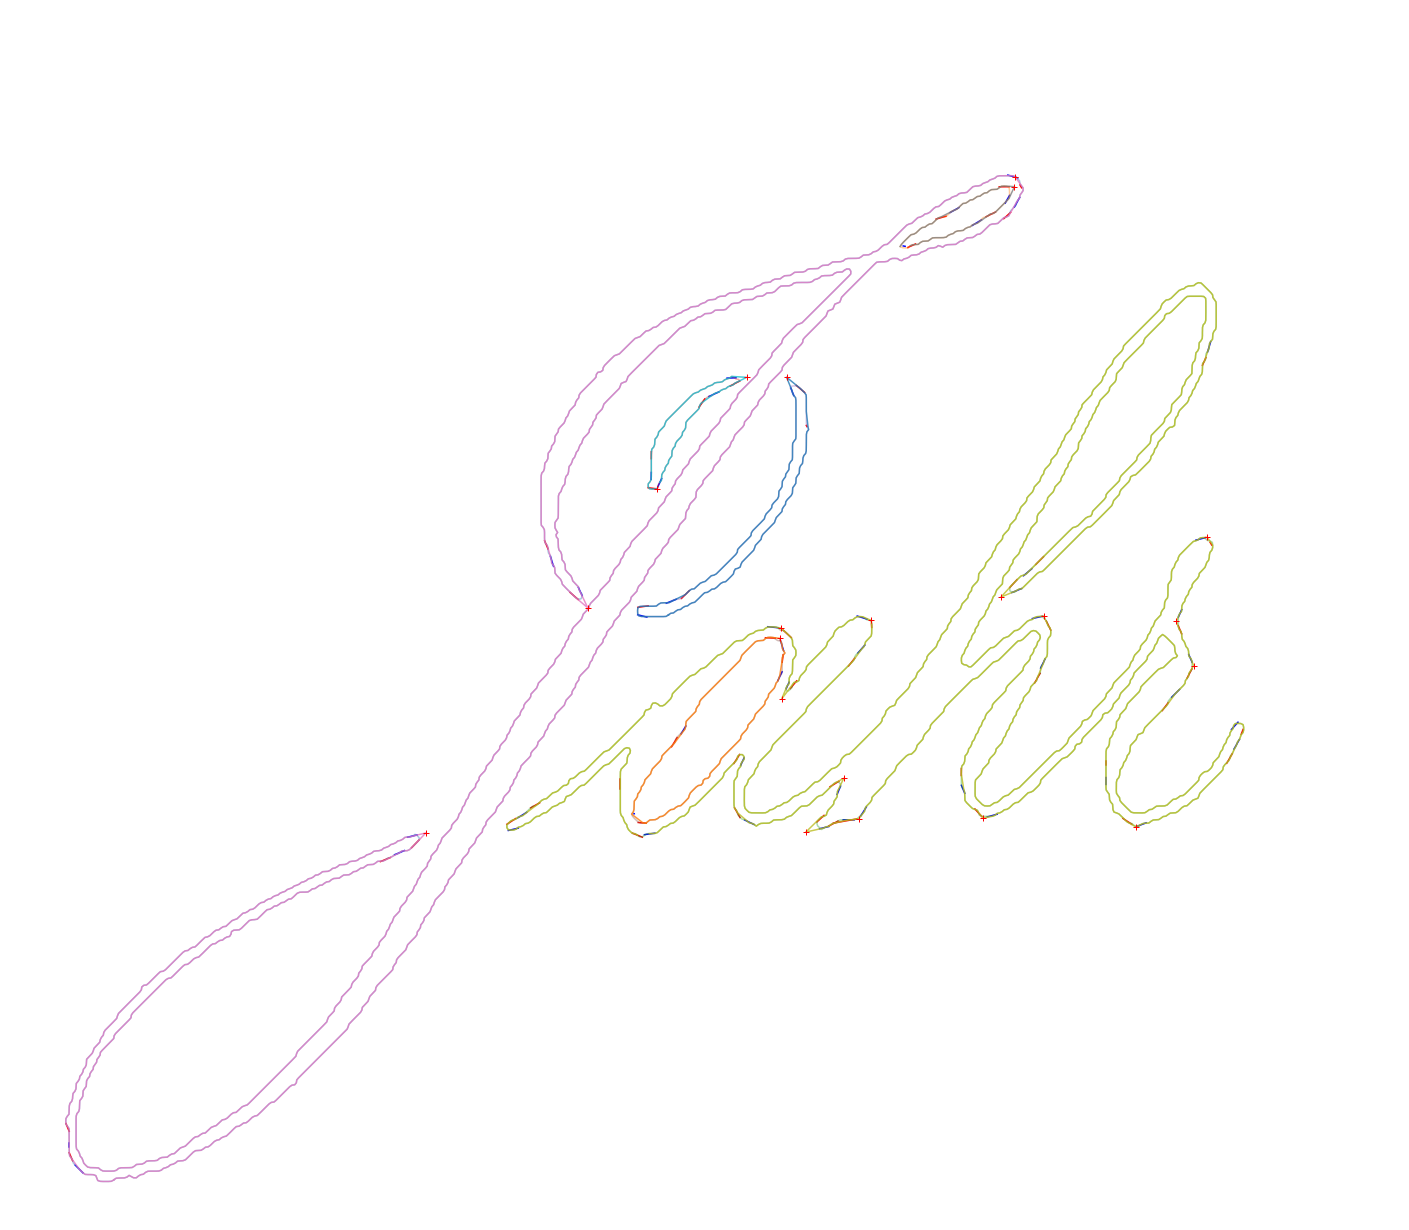

In [239]:
# Fit line to points left and right of extremum and check for their crossing angle

# Functions to get left/right neighbor points
def get_neighbour_points(points_array: np.ndarray, index: int, before: bool, n: int, min_distance: int = 0):
    lower_index = index - min_distance - n if before else index + 1 + min_distance
    upper_index = index - min_distance if before else index + 1 + min_distance + n
    # Standard case
    if (lower_index >= 0 and upper_index < len(points_array)) or (lower_index < 0 and upper_index < 0):
        return points_array[lower_index:upper_index]
    # Edge case when it goes around the start/end of the array
    else:
        return np.concatenate([points_array[lower_index:], points_array[0:upper_index % len(points_array)]])


def get_left_neighbours(points_array: np.ndarray, index: int, n: int, min_distance: int = 0):
    return get_neighbour_points(points_array, index, True, n, min_distance)


def get_right_neighbours(points_array: np.ndarray, index: int, n: int, min_distance: int = 0):
    return get_neighbour_points(points_array, index, False, n, min_distance)


# Functions to remove left/right neighbor points
def remove_neighbour_points(points_array: np.ndarray, index: int, index_correction: int, before: bool, n: int):
    lower_index = index - n if before else index + 1
    upper_index = index if before else index + 1 + n
    l = len(points_array[0])
    # Standard case
    if (lower_index >= 0 and upper_index < l) or (lower_index < 0 and upper_index < 0):
        points_array = tuple([np.delete(points_array[0], np.s_[lower_index:upper_index], 0),
                              np.delete(points_array[1], np.s_[lower_index:upper_index], 0)])
        index -= n
        index_correction -= n
    # Case when it goes around the start/end of the array
    elif upper_index % l != 0:
        points_array = tuple(
            [np.delete(points_array[0], np.s_[lower_index:], 0), np.delete(points_array[1], np.s_[lower_index:], 0)])
        points_array = tuple([np.delete(points_array[0], np.s_[0:upper_index % l], 0),
                              np.delete(points_array[1], np.s_[0:upper_index % l], 0)])
        index -= upper_index % l
        index_correction -= upper_index % l
        # Case when it needs exactly last points
    else:
        points_array = tuple(
            [np.delete(points_array[0], np.s_[lower_index:], 0), np.delete(points_array[1], np.s_[lower_index:], 0)])
    return points_array, index, index_correction


def remove_left_neighbours(points_array: np.ndarray, index: int, index_correction: int, n: int):
    return remove_neighbour_points(points_array, index, index_correction, True, n)


def remove_right_neighbours(points_array: np.ndarray, index: int, index_correction: int, n: int):
    return remove_neighbour_points(points_array, index, index_correction, False, n)


# Helper function to remove extremum
def remove_false_positive_extremum(points_array: np.ndarray, index: int, index_correction: int, distance: int):
    # Move index to before the start point and remove right from there
    return remove_neighbour_points(points_array, index - distance - 1, index_correction, False, 2 * distance + 1)


# Function to fit a line through points using least squares fitting
# Inspired by https://appdividend.com/2021/01/18/numpy-linalg-lstsq-function-in-python/
def get_regression_line(points_array: np.ndarray):
    x = points_array[:, 0]
    A = np.array([x, np.ones(len(x))])
    y = points_array[:, 1]
    line = np.linalg.lstsq(A.T, y, rcond=None)[0]
    # Get two points for plotting and angle detection
    p0 = [points_array[0][0], line[0] * points_array[0][0] + line[1]]
    pn = [points_array[-1][0], line[0] * points_array[-1][0] + line[1]]
    return np.array([p0, pn, line])


from sympy import symbols, Eq, solve


# Function to get intersection point of two lines
def get_intersection_point(line1, line2):
    # Solve line1 = line2
    x = symbols('x')
    eq = Eq(line1[2][0] * x + line1[2][1], line2[2][0] * x + line2[2][1])
    solution = solve(eq)[0]
    return solution, line1[2][0] * solution + line1[2][1]


# Function to get angle between two lines
def get_angle_between(line1, line2):
    direction1 = line1[1] - line1[0]
    direction2 = line2[1] - line2[0]
    return np.arccos(np.dot(direction1, direction2) / (np.hypot(*direction1) * np.hypot(*direction2))) * 180 / np.pi


# Number of contour points to fit line to/calculate average over
line_neighbours = 5
avg_neighbours = 15

# Number of contour points next to extremum to not take into account
line_min_distance = 0
avg_min_distance = -2

# Minimum angle (in degrees) between lines to take them as corner
min_angle = 35

# Minimum curvature difference and angle to keep extremum
min_curvature_difference = 0.15
min_angle_similar_curvature = 35

# Maximum difference between original point and new point
max_difference = 5

# Number of contour points to replace in each direction
points_to_replace = 2

# Number of contour points to smoothen in each direction
points_to_smoothen = 2  # < min_distance

corner_points = []
contours_drawn_to_corners = []
for i, contour_extrema in enumerate(peaks_and_dips_with_min_distance):
    contour_points = contours_with_curvatures[i]
    index_correction = 0
    if len(contour_extrema) > 0:
        for extremum in contour_extrema[:, 0]:
            extremum += index_correction
            # Get lines
            left = get_left_neighbours(contour_points[0], extremum, line_neighbours, line_min_distance)
            right = get_right_neighbours(contour_points[0], extremum, line_neighbours, line_min_distance)
            left_line = get_regression_line(left)
            right_line = get_regression_line(right)
            plt.plot(right_line[:-1, 0], right_line[:-1, 1], 'b-')
            plt.plot(left_line[:-1, 0], left_line[:-1, 1], 'r-')

            # Get angle between lines
            angle = get_angle_between(left_line, right_line)

            # Get average curvatures
            left_avg = np.average(get_left_neighbours(contour_points[1], extremum, avg_neighbours, avg_min_distance))
            right_avg = np.average(get_right_neighbours(contour_points[1], extremum, avg_neighbours, avg_min_distance))

            # Compare curvatures
            if np.abs(
                    left_avg - right_avg) < min_curvature_difference and angle < min_angle_similar_curvature:
                # Remove the extremum and its close surroundings if not classified as corner point
                contour_points, extremum, index_correction = remove_false_positive_extremum(contour_points, extremum,
                                                                                            index_correction,
                                                                                            points_to_smoothen)
                continue

            if angle > min_angle:
                intersection_point = get_intersection_point(left_line, right_line)

                # Append and drag contour to new corners.
                # Only do so if corner not further away than max difference
                diff = contour_points[0][extremum] - intersection_point
                if np.hypot(float(diff[0]), float(diff[1])) < max_difference:
                    corner_points.append(intersection_point)

                    contour_points, extremum, index_correction = remove_left_neighbours(contour_points, extremum,
                                                                                        index_correction,
                                                                                        points_to_replace)
                    contour_points[0][extremum] = intersection_point
                    contour_points, extremum, index_correction = remove_right_neighbours(contour_points, extremum,
                                                                                         index_correction,
                                                                                         points_to_replace)
            else:
                # Remove the extremum and its close surroundings if not classified as corner point
                contour_points, extremum, index_correction = remove_false_positive_extremum(contour_points, extremum,
                                                                                            index_correction,
                                                                                            points_to_smoothen)

    # Save new contour points
    contours_drawn_to_corners.append(contour_points[0])

corner_points = np.asarray(corner_points)
contours_drawn_to_corners = np.asarray(contours_drawn_to_corners, dtype=object)

# Show corners and contour
plt.imshow(image_cleaned, alpha=0)  # invisible, only for shape of plot
for contour in contours_with_curvatures:
    plt.plot(contour[0][:, 0], contour[0][:, 1], alpha=0.4)
for contour in contours_drawn_to_corners:
    plt.plot(contour[:, 0], contour[:, 1], alpha=0.8)
plt.plot(corner_points[:, 0], corner_points[:, 1], 'r+')
#plt.savefig('test-files/test.png', dpi=1200)

## Split by corners

In [240]:
from mpire import WorkerPool


def split_contour_by_corners(contour, corners, contour_is_closed=True):
    import numpy as np

    segments = []
    first_segmentation_index = -1
    last_segmentation_index = 0
    has_corner = False

    # Search contour for matching corner
    for i, pixel in enumerate(contour):
        for j, corner in enumerate(corners):
            # If two corners are too close, only take one
            if np.linalg.norm(np.float64(corners[j - 1] - corner)) < 1 and len(corners) > 1:
                continue
            # If a corner is found, create a new segment
            if np.array_equal(corner, pixel):
                if i > 0:
                    segments.append(contour[last_segmentation_index:(i + 1)])
                has_corner = True
                last_segmentation_index = i
                if first_segmentation_index == -1:
                    first_segmentation_index = i

    if contour_is_closed:
        # Combine first and last segment to one segment and set start point to a corner point
        if first_segmentation_index > 0:
            combined_segment = np.concatenate([contour[last_segmentation_index:len(contour) - 1], segments[0]], axis=0)
            segments.append(combined_segment)
            segments.pop(0)
        # Handle special case when start point already is a corner
        elif first_segmentation_index == 0:
            if last_segmentation_index != 0:
                segments.append(np.concatenate([contour[last_segmentation_index:], [contour[0]]],
                                               axis=0))
            elif has_corner:
                segments.append(np.concatenate([contour, [contour[0]]], axis=0))
            else:
                segments.append(np.concatenate([contour, [contour[0]]], axis=0))

        # If there is no corner found, take contour as segment
        else:
            segments.append(contour)
    elif len(contour) - last_segmentation_index > 2:
        segments.append(contour[last_segmentation_index:])
    return segments, has_corner


if use_multiprocessing:
    parameters = []
    for contour in contours_drawn_to_corners:
        parameters.append(tuple([contour, corner_points]))

    # Start multiprocess
    with WorkerPool(use_dill=True) as pool:
        results = pool.map(split_contour_by_corners, parameters)

    results = np.asarray(results, dtype=object)

    contours_in_segments = results[:, 0]
    contour_has_corner = results[:, 1]
else:
    contours_in_segments = []
    contour_has_corner = []

    for contour in contours_drawn_to_corners:
        segments, has_corner = split_contour_by_corners(contour, corner_points)
        contours_in_segments.append(segments)
        contour_has_corner.append(has_corner)

## Curve fitting, refining and optimization

In [241]:
# Helper function from reference vectorization pipeline for refining during fitting
def moveCornersToContour(corners, contour: np.ndarray):
    import numpy as np
    # Max. 5 px, otherwise outside corner -> fallback to the closest contour point
    contour_search_distance: int = 5

    corners_corrected = []

    for corner in corners:
        # Skip if already on contour
        if any(np.equal(contour, corner).all(1)):
            #print('skipped')
            continue

        x = corner[1]
        y = corner[0]
        x_direction = 0
        y_direction = 0

        # Check in 0.1 steps
        # As pixels have distance 1 from each other, detect when close (to not miss some)
        for i in range(contour_search_distance * 10 + 1):
            # Search x
            if x_direction == 0:
                if any(np.isclose(contour, [y, x + i / 10], rtol=0.0, atol=0.51).all(1)):
                    x_direction = 1
                elif any(np.isclose(contour, [y, x - i / 10], rtol=0.0, atol=0.51).all(1)):
                    x_direction = -1

            # Search y
            if y_direction == 0:
                if any(np.isclose(contour, [y + i / 10, x], rtol=0.0, atol=0.51).all(1)):
                    y_direction = 1
                elif any(np.isclose(contour, [y - i / 10, x], rtol=0.0, atol=0.51).all(1)):
                    y_direction = -1

        # Move corner
        if x_direction != 0 and y_direction != 0:
            for i in range(contour_search_distance * 10 + 1):
                x_corr = x + (i / 10 * x_direction)
                y_corr = y + (i / 10 * y_direction)

                # Move diagonal
                closest_pixel = np.sum(np.abs(np.subtract(contour, [y_corr, x_corr])), axis=1).argmin()

                # As contour pixels are maximum 1 px apart, accepted contour pixel needs to be max 0.5 away
                if np.less_equal(np.abs(np.subtract(contour[closest_pixel], [y_corr, x_corr])), [.5, .5]).all():
                    corners_corrected.append(contour[closest_pixel])
                    #print(f'{corner} moved to {contour[closest_pixel]}')
                    break
            else:
                print(f'{corner} could not be moved to contour.')

        # Fallback to initial solution for outside corners
        else:
            distances = np.sqrt((contour[:, 0] - y) ** 2 + (contour[:, 1] - x) ** 2)
            new_corner = contour[np.argmin(distances)]
            corners_corrected.append(new_corner)
            #print('fallback', corner, 'now', new_corner)

    # Convert to numpy array
    return np.asarray(corners_corrected)

In [242]:
def add_each_bezier_to_SVG_path(beziers, svg_path, plot=True):
    """
    Add each cubic Bézier to the SVG path

    :param beziers: Béziers to append
    :param svg_path: Path string to append Béziers to
    :param plot: Whether each Bézier should be plotted or not, default: True
    :return: svg_path with appended Béziers
    """
    import numpy as np
    from libraries.fitCurves import bezier

    for bez in beziers:
        bez = np.stack(bez)
        bez = np.round(bez, 2)

        # Build SVG path according to the specification
        if svg_path == '':
            svg_path = 'M{x0},{y0} C{x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                x0=bez[0, 0],
                y0=bez[0, 1],
                x1=bez[1, 0],
                y1=bez[1, 1],
                x2=bez[2, 0],
                y2=bez[2, 1],
                x3=bez[3, 0],
                y3=bez[3, 1]
            )
        else:
            svg_path += ', {x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                x1=bez[1, 0],
                y1=bez[1, 1],
                x2=bez[2, 0],
                y2=bez[2, 1],
                x3=bez[3, 0],
                y3=bez[3, 1]
            )

        if plot:
            # Plot the composite Bézier curve
            curve = []
            for t in np.linspace(0, 1, 50):
                curve.append(bezier.q(bez, t))
            curve = np.stack(curve)
            ax.plot(curve[:, 0], curve[:, 1])

    return svg_path

In [243]:
def join_adjacent_beziers(beziers, points, n_times, max_error, split_error, min_iterations_before_split, itself):
    """
    Try to simplify the composite Bézier curve by replacing adjacent Bézier curves between two corner points with fewer curves than before

    :param beziers: Béziers between to corners
    :param points: Points between to corners that should be fitted by the Bézier curve(s)
    :param n_times: Number of join iterations, also defining number of Bézier curves to join in one try
    :param max_error: Maximum error to accept fitted Bézier curve
    :param split_error: Error threshold above which the curve is split
    :param min_iterations_before_split: Minimum number of iterations before error gets checked against split_error
    :param itself: The function (join_adjascent_beziers) itself, as it is not available in new processes
    :return: A resulting list of Bézier curves
    """
    import numpy as np
    from libraries.fitCurves.fitCurves import fitCubic, normalize

    resulting_beziers = []
    l = len(beziers)
    # Try to replace Bézier curves, always try to take n_times + 1 Béziers at once
    if l >= n_times + 1:
        all_curves_covered = False
        for i in np.arange(0, l, n_times + 1):
            if i < l - n_times:
                if i == l + n_times:
                    all_curves_covered = True
                bez1 = beziers[i]
                bez2 = beziers[i + 1:i + n_times]
                bez3 = beziers[i + n_times]
                start_index = np.nonzero(np.equal(points, bez1[0]).all(1))[0][0]
                end_index = np.nonzero(np.equal(points, bez3[3]).all(1))[0][-1]
                segment = points[start_index:] if all_curves_covered else points[start_index:end_index + 1]
                left_tangent = normalize(bez1[1] - bez1[0])
                right_tangent = normalize(bez3[2] - bez3[3])
                new_beziers = fitCubic(segment, left_tangent, right_tangent, max_error, split_error,
                                       min_iterations_before_split)
                if len(new_beziers) <= n_times + 1:
                    resulting_beziers.extend(new_beziers)
                else:
                    resulting_beziers.extend([bez1, *bez2, bez3])
            elif not all_curves_covered:
                resulting_beziers.extend([*beziers[-(l % (n_times + 1)):]])
    else:
        n_times = l
        resulting_beziers.extend(beziers)

    if n_times > 1 and (len(resulting_beziers) > 1):
        return itself(resulting_beziers, points, n_times - 1, max_error, split_error, min_iterations_before_split,
                      itself)
    else:
        return resulting_beziers

In [244]:
from libraries.fitCurves.fitCurves import *
from libraries.fitCurves import bezier
from libraries import svg

# Parameters for first Bézier fitting
max_error = 2
split_error = 30
min_iterations_before_split = 5

# Optimization parameters
optimization_steps = 25
curvature_threshold = 0.8
max_error_2 = 2
split_error_2 = 20
min_iterations_before_split_2 = 15
max_error_join = 2
join_iterations = 7

# Prepare SVG
svg_file = svg.create_file(filename_svg, np.shape(image_cleaned)[1], np.shape(image_cleaned)[0])
path_string = '\n'

# Either use multiprocessing (gain speed but loose the plot) or not
if not use_multiprocessing:
    # Prepare plot
    fig, ax = plt.subplots()
    # Use original image as background
    ax.imshow(image_cleaned, cmap='gray', interpolation='nearest')

    new_corners_from_optimization = []
    for index, contour in enumerate(contours_in_segments):
        has_corner = contour_has_corner[index]
        svg_path = ''

        # Fit a composite cubic Bézier curve to each segment
        for i, segment in enumerate(contour):
            beziers = fitCurve(segment, has_corner, max_error, split_error, min_iterations_before_split)

            # Optimize Bézier curves by splitting at high curvature values and fitting again
            high_curvature_points = []
            for j, bez in enumerate(beziers):
                curvatures = []
                for t in range(1, optimization_steps):
                    curvatures.append(bezier.curvature(bez, t / optimization_steps))

                high_curvature_indices = argrelmax(np.abs(curvatures))[0]
                for curvature_index in high_curvature_indices:
                    if np.abs(curvatures[curvature_index]) > curvature_threshold:
                        high_curvature_points.append(bezier.q(bez, curvature_index / optimization_steps))

            if len(high_curvature_points):
                new_corners = moveCornersToContour(high_curvature_points, segment)
                new_corners_from_optimization.extend(new_corners)
                new_segments, _ = split_contour_by_corners(segment, new_corners, False)
                for new_segment in new_segments:
                    new_beziers = fitCurve(new_segment, True, max_error_2, split_error_2, min_iterations_before_split_2)

                    # Further optimize by joining adjascent Bézier curves together
                    if len(new_beziers) > 1:
                        new_beziers = join_adjacent_beziers(new_beziers, new_segment, join_iterations, max_error_join,
                                                            split_error_2, min_iterations_before_split_2,
                                                            join_adjacent_beziers)

                    svg_path = add_each_bezier_to_SVG_path(new_beziers, svg_path)
            else:
                # Further optimize by joining adjacent Bézier curves together
                if len(beziers) > 1:
                    beziers = join_adjacent_beziers(beziers, segment, join_iterations, max_error_join, split_error_2,
                                                    min_iterations_before_split_2, join_adjacent_beziers)

                svg_path = add_each_bezier_to_SVG_path(beziers, svg_path)

        # Append the curve to the overall SVG path string
        path_string += f'{svg_path}Z\n'

    new_corners_from_optimization = np.asarray(new_corners_from_optimization)
    # Show the corner points
    if len(corner_points) > 0:
        ax.plot(corner_points[:, 0], corner_points[:, 1], 'r+')
    if len(new_corners_from_optimization) > 0:
        ax.plot(new_corners_from_optimization[:, 0],
                new_corners_from_optimization[:, 1], 'b+')

    plt.savefig(filename_result_figure, dpi=1200)

else:
    from mpire import WorkerPool

    params = {
        # Parameters for first Bézier fitting
        'max_error': max_error,
        'split_error': split_error,
        'min_iterations_before_split': min_iterations_before_split,

        # Optimization parameters
        'optimization_steps': optimization_steps,
        'curvature_threshold': curvature_threshold,
        'max_error_2': max_error_2,
        'split_error_2': split_error_2,
        'min_iterations_before_split_2': min_iterations_before_split_2,
        'max_error_join': max_error_join,
        'join_iterations': join_iterations
    }


    # Define the worker function
    def fit_contour_parallel(sharedObjects, contour, has_corner):
        from libraries.fitCurves.fitCurves import fitCurve
        from libraries.fitCurves import bezier
        from scipy.signal import argrelmax
        import numpy as np

        p = sharedObjects[0]
        moveCornersToContour = sharedObjects[1]
        add_each_bezier_to_SVG_path = sharedObjects[2]
        join_adjacent_beziers = sharedObjects[3]
        new_corners_from_optimization = sharedObjects[4]
        split_contour_by_corners = sharedObjects[5]

        svg_path = ''
        # Fit a composite cubic Bézier curve to each segment
        for i, segment in enumerate(contour):
            beziers = fitCurve(segment, has_corner, p['max_error'], p['split_error'], p['min_iterations_before_split'])

            # Improve corner detection by splitting at high curvature values and fitting again
            high_curvature_points = []
            for j, bez in enumerate(beziers):
                curvatures = []
                for t in range(1, p['optimization_steps']):
                    curvatures.append(bezier.curvature(bez, t / p['optimization_steps']))

                high_curvature_indices = argrelmax(np.abs(curvatures))[0]
                for curvature_index in high_curvature_indices:
                    if np.abs(curvatures[curvature_index]) > p['curvature_threshold']:
                        high_curvature_points.append(bezier.q(bez, curvature_index / p['optimization_steps']))

            if len(high_curvature_points):
                new_corners = moveCornersToContour(high_curvature_points, segment)
                new_corners_from_optimization.extend(new_corners)
                new_segments, _ = split_contour_by_corners(segment, new_corners, False)
                for new_segment in new_segments:
                    new_beziers = fitCurve(new_segment, True, p['max_error_2'], p['split_error_2'],
                                           p['min_iterations_before_split_2'])

                    # Further optimize by joining adjacent Bézier curves together
                    if len(new_beziers) > 1:
                        new_beziers = join_adjacent_beziers(new_beziers,
                                                            new_segment, p['join_iterations'], p['max_error_join'],
                                                            p['split_error_2'], p['min_iterations_before_split_2'],
                                                            join_adjacent_beziers)

                    svg_path = add_each_bezier_to_SVG_path(new_beziers, svg_path, False)
            else:
                # Further optimize by joining adjacent Bézier curves together
                if len(beziers) > 1:
                    beziers = join_adjacent_beziers(beziers, segment, p['join_iterations'], p['max_error_join'],
                                                    p['split_error_2'], p['min_iterations_before_split_2'],
                                                    join_adjacent_beziers)

                svg_path = add_each_bezier_to_SVG_path(beziers, svg_path, False)

        return f'{svg_path}Z\n'


    new_corners_from_optimization = []
    parameters = []
    for i, contour in enumerate(contours_in_segments):
        parameters.append((contour, contour_has_corner[i]))

    # Start multiprocess fitting
    with WorkerPool(use_dill=True, shared_objects=(
            params, moveCornersToContour, add_each_bezier_to_SVG_path, join_adjacent_beziers,
            new_corners_from_optimization,
            split_contour_by_corners)) as pool:
        svg_paths = pool.map(fit_contour_parallel, parameters)

    # Append the curve to the overall SVG path string
    for svg_path in svg_paths:
        path_string += svg_path

# Add path to SVG file and save
svg.add_path_element(svg_file, path_string)
svg.save_file(svg_file)